In [164]:
import numpy as np
import pymc3 as pm
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az

In [91]:
import matplotlib.style as style
style.use('fivethirtyeight')
FIGSIZE = (12,6)

### Question 1

In [127]:
# of samples on the grid
samples = 3000

tosses = 15
water_count = 4

# create 1-dimensional grid 
grid = np.linspace(0, 1, samples)

# flat prior
prior = np.repeat(5, samples)

# probability mass function
likelihood = stats.binom.pmf(water_count, tosses, grid)

posterior = likelihood * prior
# normalize:
norm_posterior = posterior / posterior.max()

In [128]:
np.repeat(5, tosses)

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

In [129]:
posterior[0:25]

array([0.00000000e+00, 8.40627480e-11, 1.34007722e-09, 6.75928234e-09,
       2.12843665e-08, 5.17732517e-08, 1.06963242e-07, 1.97435530e-07,
       3.35580070e-07, 5.35560796e-07, 8.13281203e-07, 1.18635027e-06,
       1.67404875e-06, 2.29729579e-06, 3.07861586e-06, 4.04210613e-06,
       5.21340407e-06, 6.61965545e-06, 8.28948263e-06, 1.02529533e-05,
       1.25415492e-05, 1.51881359e-05, 1.82269320e-05, 2.16934792e-05,
       2.56246125e-05])

In [130]:
likelihood[0:25]

array([0.00000000e+00, 1.68125496e-11, 2.68015444e-10, 1.35185647e-09,
       4.25687330e-09, 1.03546503e-08, 2.13926483e-08, 3.94871061e-08,
       6.71160141e-08, 1.07112159e-07, 1.62656241e-07, 2.37270055e-07,
       3.34809751e-07, 4.59459157e-07, 6.15723172e-07, 8.08421226e-07,
       1.04268081e-06, 1.32393109e-06, 1.65789653e-06, 2.05059065e-06,
       2.50830985e-06, 3.03762719e-06, 3.64538640e-06, 4.33869583e-06,
       5.12492250e-06])

In [131]:
def plot_likelihoods(norm_posterior, likelihood):
    fig = plt.figure(figsize=FIGSIZE)
    #fig.mouseover = True

    plot_post = plt.plot(grid, norm_posterior, label="normalized posterior")
    plot_like = plt.plot(grid, likelihood, label="Likelihood")
    plt.legend(loc=0)
    plt.show()

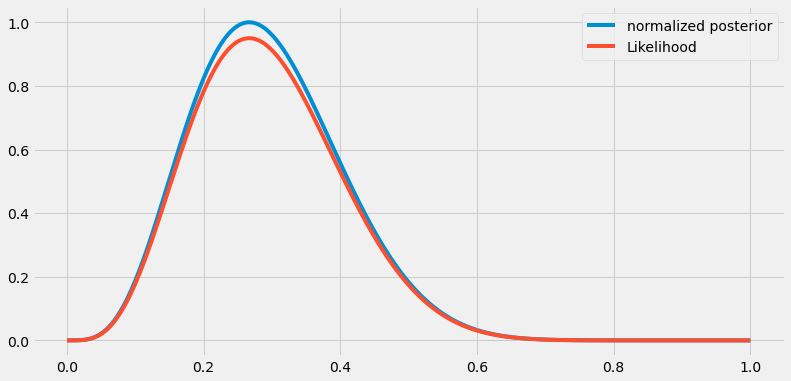

In [132]:
norm_likelihood = 0.95 * likelihood / likelihood.max()
plot_likelihoods(norm_posterior, norm_likelihood)

In [137]:
for n, i in enumerate(norm_posterior):
    if i == max(norm_posterior):
        print(f"Max likelihood found at sample {n} of {samples}, or {round(n * (100/samples),2)}%")

Max likelihood found at sample 800 of 3000, or 26.67%


In [138]:
# vs. the actual ratio:
round(100 * 4/15,2)

26.67

### Question 2
As with 1, but a binary prior of 0 below 0.5 and constant above 0.5. what difference does this make?


In [153]:
# of samples on the grid
samples = 1000

tosses = 15
water_count = 4

# create 1-dimensional grid 
grid = np.linspace(0, 1, samples)

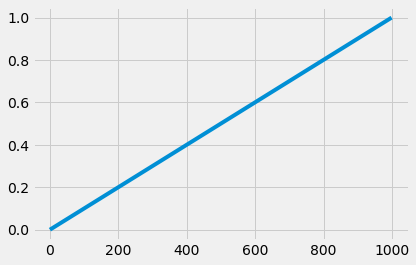

In [154]:
# grid is linear
plt.plot(grid)

In [156]:
# Because it's linear, we can do this:

# returns True/False for values below/above 0.5
binary_prior = grid > 0.5

# convert to ints
binary_prior = binary_prior.astype(int)
binary_prior[0:25]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0])

In [171]:
prior = binary_prior

# probability mass function
likelihood = stats.binom.pmf(water_count, tosses, grid)

posterior = likelihood * prior
# normalize:
binary_norm_posterior = posterior / posterior.max()

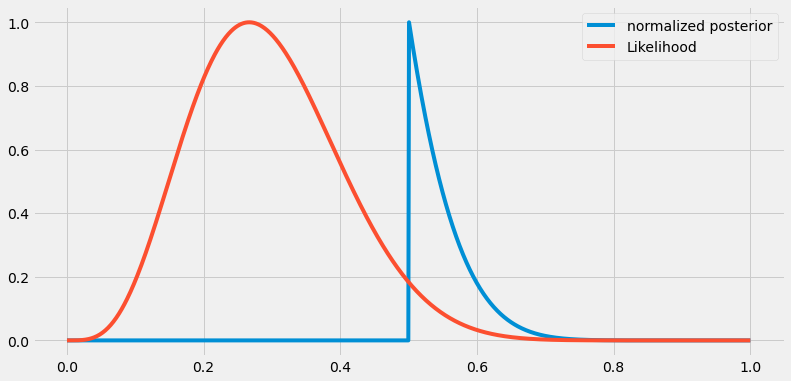

In [172]:
norm_likelihood = likelihood / likelihood.max()
plot_likelihoods(binary_norm_posterior, norm_likelihood)

In [179]:
for n, i in enumerate(binary_norm_posterior):
    if i == max(binary_norm_posterior):
        print(f"Max likelihood found at sample {n} of {samples}, or {round(n * (100/samples),2)}%")

Max likelihood found at sample 500 of 1000, or 50.0%


### Question 3 
Compute 89th pctile and HPDI intervals from #2. which is wider & why? If you only had the information in the interval, what might you misunderstand about the posterior?

In [180]:
len(binary_norm_posterior)

1000

In [181]:
# The author's R package has functions to calculate these:
# https://rdrr.io/github/rmcelreath/rethinking/man/HPDI.html

# https://github.com/rmcelreath/rethinking/blob/3b48ec8dfda4840b9dce096d0cb9406589ef7923/man/HPDI.Rd

# Python equivalent is:
#https://arviz-devs.github.io/arviz/api/generated/arviz.hdi.html

# HPDI: 
az.hdi(binary_norm_posterior, 0.89)

array([0.        , 0.14628299])

In [176]:
# alternate method
# from https://github.com/aloctavodia/Doing_bayesian_data_analysis/blob/master/hpd.py

def calc_min_interval(x, alpha):
    """Internal method to determine the minimum interval of a given width
    Assumes that x is sorted numpy array.
    """

    n = len(x)
    cred_mass = 1.0-alpha

    interval_idx_inc = int(np.floor(cred_mass*n))
    n_intervals = n - interval_idx_inc
    interval_width = x[interval_idx_inc:] - x[:n_intervals]

    if len(interval_width) == 0:
        raise ValueError('Too few elements for interval calculation')

    min_idx = np.argmin(interval_width)
    hdi_min = x[min_idx]
    hdi_max = x[min_idx+interval_idx_inc]
    return hdi_min, hdi_max


def hpd(x, alpha=0.05):
    """Calculate highest posterior density (HPD) of array for given alpha. 
    The HPD is the minimum width Bayesian credible interval (BCI).
    :Arguments:
        x : Numpy array
        An array containing MCMC samples
        alpha : float
        Desired probability of type I error (defaults to 0.05)
    """

    # Make a copy of trace
    x = x.copy()
    # For multivariate node
    if x.ndim > 1:
        # Transpose first, then sort
        tx = np.transpose(x, list(range(x.ndim))[1:]+[0])
        dims = np.shape(tx)
        # Container list for intervals
        intervals = np.resize(0.0, dims[:-1]+(2,))

        for index in make_indices(dims[:-1]):
            try:
                index = tuple(index)
            except TypeError:
                pass

            # Sort trace
            sx = np.sort(tx[index])
            # Append to list
            intervals[index] = calc_min_interval(sx, alpha)
        # Transpose back before returning
        return np.array(intervals)
    else:
        # Sort univariate node
        sx = np.sort(x)
        return np.array(calc_min_interval(sx, alpha))

In [178]:
# alpha appears to be equivalent to 1 - prob
hpd(binary_norm_posterior, alpha=0.11)

array([0.        , 0.14628299])

In [207]:
correct_hpdi = [0.5005005, 0.6026026]
correct_pi = [0.5025025, 0.6306306]

In [328]:
def pct_diff(array1, array2, dec_places=5):
    # calculate percent-wise differences
    for n, i in enumerate(array1):
        diff = round(100 * np.abs(i - array2[n]) / np.mean([i, array2[n]]),dec_places)
        print(f"element {n} value: {i}; difference: {diff} %")
    

In [329]:
# Ok, so the posterior is normalized, which I think is why the data isn't coming back correctly.
# The HPD function also expects samples.

In [336]:

# np expects the probability input to sum to 1, so normalize:
bn_p = binary_norm_posterior / binary_norm_posterior.sum()

binary_norm_samples = np.random.choice(grid, size=50000, replace=True, p=bn_p)


In [341]:
my_hpdi = hpd(binary_norm_samples, alpha=0.12)
my_hpdi

array([0.5005005, 0.6026026])

In [342]:
pct_diff(my_hpdi, correct_hpdi)

element 0 value: 0.5005005005005005; difference: 0.0 %
element 1 value: 0.6026026026026026; difference: 0.0 %


In [224]:
# There's an off-by-1 error in one of these libraries,
# or some issue translating alpha to probability mass. 
# Expected behavior would be hpd(samples, alpha=0.11) is equiv to HPDI( samples , 0.89)
# but we see hpd(samples, alpha=0.12) being equivalent instead.

In [381]:
def pi(samples, prob=0.89):
    # Return the bounds of the distribution, centered around the median.
    
    quantile_grid = np.linspace(0, 1, 1001) # 0 to 1 inclusive. 0.1% intervals
    sorted_samples = np.sort(samples)
    quantiles = np.quantile(sorted_samples, quantile_grid)
    
    index = int(len(quantile_grid) * (1-prob)/2) + 1
    low_idx = bn_quantiles[index]
    hi_idx = bn_quantiles[-index]
    return low_idx, hi_idx


In [382]:
my_pi = pi(sorted_samples, prob=0.89)
my_pi

(0.5035035035035035, 0.6316316316316316)

In [383]:
correct_pi

[0.5025025, 0.6306306]

In [384]:
# Reasonable difference, given that these are based on random sampling
pct_diff(my_pi, correct_pi)

element 0 value: 0.5035035035035035; difference: 0.19901 %
element 1 value: 0.6316316316316316; difference: 0.15861 %


In [385]:
correct_hpdi, correct_pi

([0.5005005, 0.6026026], [0.5025025, 0.6306306])

In [386]:
# HPDI interval
correct_hpdi[1] - correct_hpdi[0]

0.10210209999999997

In [387]:
# PI interval
correct_pi[1] - correct_pi[0]

0.12812810000000008

### So, PI is wider but shifted to the right a little bit
## Question 3
### Why? 

HPDI is "the shortest interval for which the difference in the cdf values of the endpoints is the nominal probability."  That is, HPDI specifically looks for the narrowest range that includes the specified proportion of values, while the "naive" PI is simply centered around the median.


### If you only had the information in the interval, what might you misunderstand about the posterior?

The posterior is truncated with a sharp left edge. If looking at the interval alone, one might assume the posterior is a smoother, narrower binomial distribution.